In [1]:
import matplotlib.pyplot
%matplotlib inline
import time
import numpy as np

In [2]:
train_img = "./dataset/train-images.idx3-ubyte"
train_lbl = "./dataset/train-labels.idx1-ubyte"

test_img = "./dataset/t10k-images.idx3-ubyte"
test_lbl = "./dataset/t10k-labels.idx1-ubyte"

In [3]:
def ubyte2csv(imgs, lbls, output_file, no_of_imgs):
    img_arr = open(imgs,'rb')
    lbl_arr = open(lbls, 'rb')
    csv_file = open(output_file, 'w')

    img_arr.read(16)
    lbl_arr.read(8)
    images = []

    for i in range(no_of_imgs):
        image = [ord(lbl_arr.read(1))]
        for j in range(28*28):
            image.append(ord(img_arr.read(1)))
        images.append(image)

    for img in images:
        csv_file.write(",".join(str(pix) for pix in img) + "\n")
    img_arr.close()
    lbl_arr.close()
    csv_file.close()


In [4]:
# ubyte2csv(train_img, train_lbl, "./dataset/train.csv", 60000)
# ubyte2csv(test_img,test_lbl, "./dataset/test.csv", 10000)

In [5]:
train_file = open("./dataset/train.csv")
train_list = train_file.readlines()
train_file.close()
print(len(train_list))

60000


In [6]:
train_list[123]

'7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,113,113,113,114,238,253,253,253,255,206,88,0,0,0,0,0,0,0,0,0,0,0,0,0,57,85,147,234,252,252,252,253,252,252,252,252,253,252,246,75,0,0,0,0,0,0,0,0,0,0,67,197,234,252,253,252,252,252,252,196,195,195,195,195,253,252,252,84,0,0,0,0,0,0,0,0,0,0,85,252,252,252,225,223,114,84,84,0,0,0,0,16,253,252,214,28,0,0,0,0,0,0,0,0,0,0,38,221,157,112,0,0,0,0,0,0,0,0,16,203,253,252,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,207,253,255,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,252,252,215,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

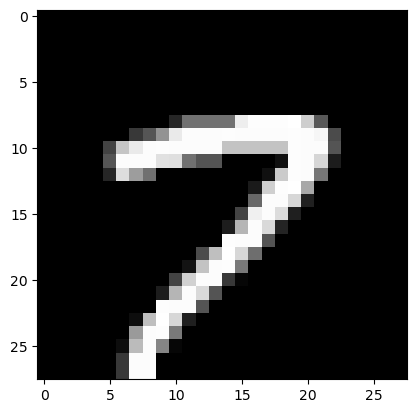

In [7]:
values = train_list[123].split(",")
image_array = np.asfarray(values[1:]).reshape(28,28)
matplotlib.pyplot.imshow(image_array,cmap="gray", interpolation=None)

In [8]:
test_file = open("./dataset/test.csv")
test_list = test_file.readlines()
test_file.close()
print(len(test_list))

10000


In [9]:
class DNN:
    def __init__(self, sizes=[784,128,64,10], epochs=10, lr=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr

        input_layer = sizes[0]
        hidden_1 = sizes[1]
        hidden_2 = sizes[2]
        output_layer = sizes[3]

        self.params = {
            'W1':np.random.randn(hidden_1,input_layer)*np.sqrt(1./hidden_1),
            'W2':np.random.randn(hidden_2,hidden_1)*np.sqrt(1./hidden_2),
            'W3':np.random.randn(output_layer,hidden_2)*np.sqrt(1./hidden_2)
        }
    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1+np.exp(-x))

    def softmax(self, x, derivative=False):
        exps = np.exp(x-x.max())
        if derivative:
            return exps/np.sum(exps, axis=0)*(1-exps/np.sum(exps, axis=0))
        return exps/np.sum(exps, axis=0)


    def forward_pass(self, x_train):
        params = self.params
        params['A0'] = x_train

        params['Z1'] = np.dot(params['W1'], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        params['Z2'] = np.dot(params['W2'], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        params['Z3'] = np.dot(params['W3'], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['Z3']
    def backward_pass(self, y_train, output):
        params = self.params

        change_w = {}

        error = 2*(output- y_train)/output.shape[0]*self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error)*self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params["A1"])

        error = np.dot(params['W2'].T, error)*self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w
    
    def update_weights(self, change_w):
        for key, val in change_w.items():
            self.params[key] -= self.lr*val 

    def compute_accuracy(self, test_data):
        predictions = []
        for x in test_data:
            values = x.split(",")
            inputs = (np.asfarray(values[1:]))/255.0*0.99 + 0.01
            targets = np.zeros(10) + 0.01
            targets[int(values[0])] = 0.99
            output = self.forward_pass(inputs)
            pred = np.argmax(output)
            predictions.append(pred==np.argmax(targets))
        
        return np.mean(predictions)

    def train(self, train_list, test_list):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x in train_list:
                values = x.split(",")
                inputs = (np.asfarray(values[1:])/255.0*0.99) + 0.01
                targets = np.zeros(10) + 0.01
                targets[int(values[0])] = 0.99
                output = self.forward_pass(inputs)
                change_w = self.backward_pass(targets, output)
                self.update_weights(change_w)
            
            accuracy = self.compute_accuracy(test_list)
            print('Epoch: {0}, Time Taken: {1:.2f}s, Accuracy: {2:.2f}%'.format(iteration+1, time.time() - start_time, accuracy*100))


In [10]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=10, lr=0.001)
dnn.train(train_list, test_list)

Epoch: 1, Time Taken: 27.75s, Accuracy: 14.33%
Epoch: 2, Time Taken: 55.80s, Accuracy: 22.37%
Epoch: 3, Time Taken: 84.90s, Accuracy: 30.15%
Epoch: 4, Time Taken: 112.16s, Accuracy: 36.93%
Epoch: 5, Time Taken: 144.17s, Accuracy: 42.36%
Epoch: 6, Time Taken: 176.15s, Accuracy: 46.79%
Epoch: 7, Time Taken: 207.06s, Accuracy: 50.60%
Epoch: 8, Time Taken: 238.79s, Accuracy: 53.98%
Epoch: 9, Time Taken: 271.48s, Accuracy: 56.46%
Epoch: 10, Time Taken: 303.55s, Accuracy: 58.80%
